# Análisis Exploratorio de Datos: Exoplanetas y Estrellas Anfitrionas

Este cuaderno reproduce el Análisis Exploratorio de Datos (EDA) realizado sobre el conjunto de datos de exoplanetas extraído de bases de datos públicas. El objetivo es investigar cómo las propiedades de las estrellas influyen en las de sus exoplanetas.

## 1. Carga y Preprocesamiento de Datos

Cargamos el archivo CSV, examinamos su estructura y realizamos la preparación necesaria para el análisis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer el conjunto de datos
data_path = 'Data/exoplaneteu_catalog-1.csv'
df = pd.read_csv(data_path, sep=';', low_memory=False)

print('Dimensiones del conjunto de datos:', df.shape)
df.head()

Dimensiones del conjunto de datos: (7782, 98)


,name,discovered,updated,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,...,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names,planet_status,publication,mass_measurement_type,radius_measurement_type
0,TOI-2844 b,2024,2025-01-20,54.0000,5.30000,4.90000,NaN,NaN,NaN,0.7750,...,6910.0,210.0,210.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
1,TOI-286 c,2024,2024-06-11,0.0117,0.00698,0.00698,NaN,NaN,NaN,0.1677,...,5132.0,12.0,12.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
2,TOI-2986 b,2025,2025-07-03,0.3040,0.08600,0.06700,NaN,NaN,NaN,0.8290,...,5906.0,69.0,66.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
3,TOI-3023 b,2022,2022-10-31,0.6200,0.10000,0.10000,NaN,NaN,NaN,1.4660,...,5760.0,88.0,88.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
4,TOI-3321 Ab,2024,2025-02-11,0.5540,0.07600,0.07600,NaN,NaN,NaN,1.3900,...,5850.0,140.0,140.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit


### 1.1 Ingeniería de Características

Derivamos columnas adicionales:

- `spec_class`: clase espectral simplificada obtenida de la primera letra de la columna `star_sp_type`.
- `is_giant`: indicador booleano de si un planeta se considera gigante (masa ≥ 0,3 $M_{Jup}$ o radio ≥ 0,6 $R_{Jup}$).

In [2]:
# Derivar clase espectral
df['spec_class'] = df['star_sp_type'].astype(str).str[0].str.upper()
df['spec_class'] = df['spec_class'].where(df['spec_class'].isin(list('OBAFGKM')), 'Other')

# Función para clasificar planetas gigantes
def es_gigante(fila):
    masa = fila['mass']
    radio = fila['radius']
    return (pd.notnull(masa) and masa >= 0.3) or (pd.notnull(radio) and radio >= 0.6)

# Aplicar clasificación
df['is_giant'] = df.apply(es_gigante, axis=1)

# Vista previa de columnas derivadas
df[['name','spec_class','mass','radius','is_giant']].head()

,name,spec_class,mass,radius,is_giant
0,TOI-2844 b,Other,54.0000,0.7750,True
1,TOI-286 c,K,0.0117,0.1677,False
2,TOI-2986 b,G,0.3040,0.8290,True
3,TOI-3023 b,Other,0.6200,1.4660,True
4,TOI-3321 Ab,G,0.5540,1.3900,True


## 2. Visión General de los Datos

Examinamos patrones de valores faltantes, entradas duplicadas y estadísticas básicas.

In [3]:
# Porcentaje de valores faltantes por columna
porc_faltantes = df.isnull().mean() * 100
porc_faltantes.sort_values(ascending=False).head(15)

hot_point_lon                 99.948599
star_magnetic_field           99.922899
geometric_albedo_error_min    99.794397
geometric_albedo_error_max    99.794397
geometric_albedo              99.781547
tzero_vr_error_max            99.408892
tzero_vr_error_min            99.408892
tzero_vr                      99.370342
tzero_tr_sec_error_max        99.331791
tzero_tr_sec_error_min        99.331791
tzero_tr_sec                  99.318941
log_g                         99.151889
star_detected_disc            98.535081
lambda_angle                  98.059625
lambda_angle_error_max        98.046775
dtype: float64

In [4]:
# Comprobación de duplicados por nombre de planeta
num_duplicados = df.duplicated(subset=['name']).sum()
print('Número de planetas duplicados:', num_duplicados)

Número de planetas duplicados: 0


In [5]:
# Estadísticas descriptivas para variables numéricas
cols_numericas = df.select_dtypes(include=[np.number]).columns
df[cols_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
discovered,7782.0,2015.663968,5.943856,1.988000e+03,2014.000000,2016.000,2020.00000,2025.00
mass,3663.0,14.940362,20.513623,1.420000e-09,0.131900,2.500,27.00000,78.27
mass_error_min,4042.0,2.502411,5.801482,0.000000e+00,0.012770,0.110,1.70000,56.10
mass_error_max,4032.0,3.516642,29.970306,-1.780000e+01,0.010987,0.104,1.89625,1635.00
mass_sini,1465.0,6.404820,12.462423,4.700000e-04,0.064800,1.210,5.58000,70.00
...,...,...,...,...,...,...,...,...
star_age_error_min,3425.0,0.375520,2.814897,-7.410000e+00,-1.770000,0.390,2.00000,86.00
star_age_error_max,3425.0,2.855920,10.053281,-2.600000e+00,0.850000,2.090,4.00000,500.00
star_teff,6205.0,5441.236702,1911.898047,1.300000e+03,4850.000000,5526.000,5902.00000,42065.00
star_teff_error_min,5864.0,121.275367,320.829194,-9.823110e+01,61.045000,100.000,133.00000,15000.00


## 3. Análisis Univariado

### 3.1 Distribución de Clases Espectrales de Estrellas

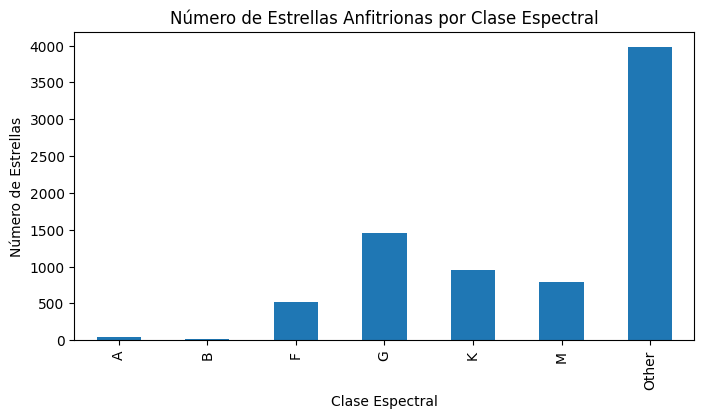

In [6]:
conteo_especies = df['spec_class'].value_counts().sort_index()

plt.figure(figsize=(8,4))
conteo_especies.plot(kind='bar')
plt.title('Número de Estrellas Anfitrionas por Clase Espectral')
plt.xlabel('Clase Espectral')
plt.ylabel('Número de Estrellas')
plt.show()

### 3.2 Radio Planetario por Clase Espectral

C:\Users\sebas\AppData\Local\Temp\ipykernel_22132\1305328728.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_radio, labels=clases)


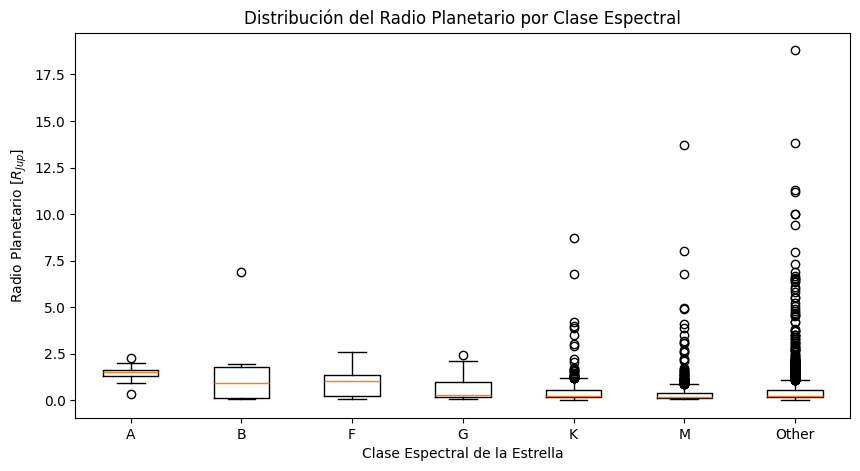

In [7]:
plt.figure(figsize=(10,5))
clases = conteo_especies.index
datos_radio = [df[df['spec_class']==c]['radius'].dropna() for c in clases]
plt.boxplot(datos_radio, labels=clases)
plt.title('Distribución del Radio Planetario por Clase Espectral')
plt.xlabel('Clase Espectral de la Estrella')
plt.ylabel('Radio Planetario [$R_{Jup}$]')
plt.show()

## 4. Análisis Bivariado

### 4.1 Masa Estelar vs Masa Planetaria

Exploramos la relación entre la masa de la estrella y la masa del planeta.

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
C:\Users\sebas\AppData\Local\Temp\ipykernel_22132\2468770995.py:5: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Masa Estelar [$M_{\odot}$]')


Coeficiente de correlación de Pearson: -0.048247833014850965


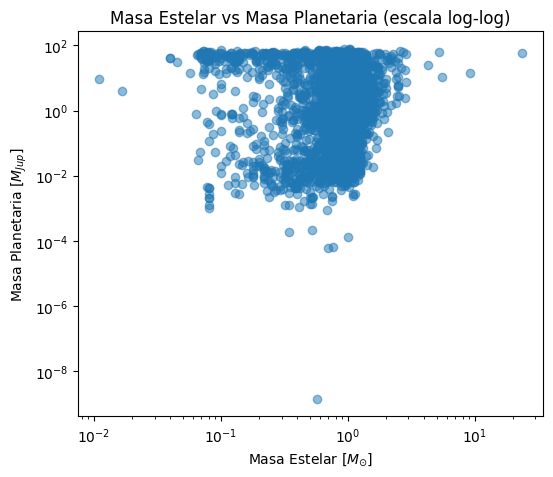

In [8]:
plt.figure(figsize=(6,5))
plt.scatter(df['star_mass'], df['mass'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Masa Estelar [$M_{\odot}$]')
plt.ylabel('Masa Planetaria [$M_{Jup}$]')
plt.title('Masa Estelar vs Masa Planetaria (escala log-log)')

# Calcular la correlación descartando NaN
valida = df[['star_mass','mass']].dropna()
correlacion = valida['star_mass'].corr(valida['mass'])
print('Coeficiente de correlación de Pearson:', correlacion)

plt.show()

### 4.2 Fracción de Planetas Gigantes por Clase Espectral

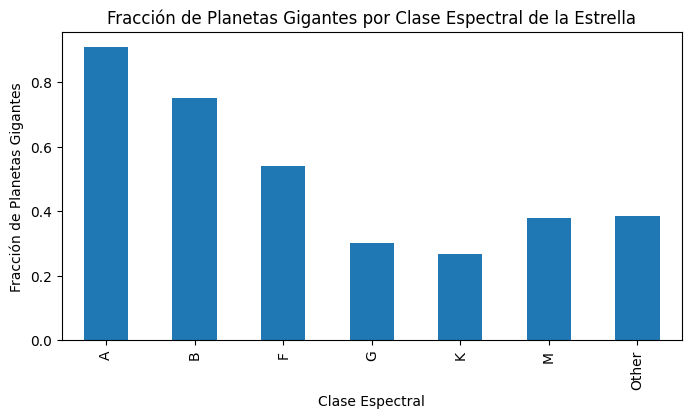

In [9]:
fraccion_gigantes = df.groupby('spec_class')['is_giant'].mean()

plt.figure(figsize=(8,4))
fraccion_gigantes.plot(kind='bar')
plt.title('Fracción de Planetas Gigantes por Clase Espectral de la Estrella')
plt.xlabel('Clase Espectral')
plt.ylabel('Fracción de Planetas Gigantes')
plt.show()

### 4.3 Número de Descubrimientos por Año

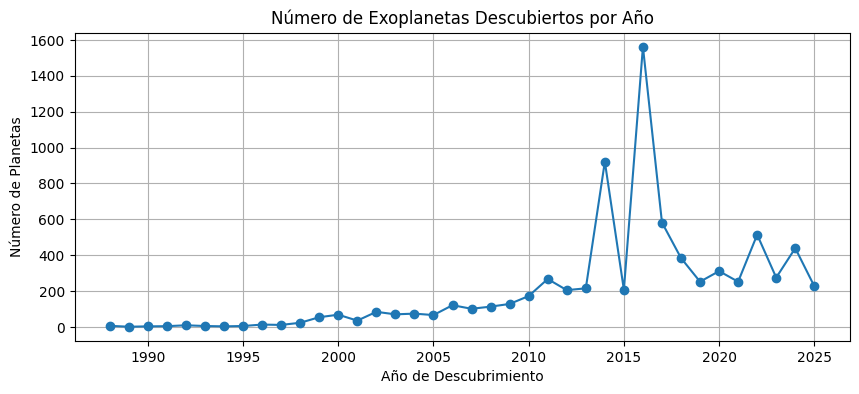

In [10]:
descubrimientos_anuales = df['discovered'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.plot(descubrimientos_anuales.index, descubrimientos_anuales.values, marker='o')
plt.title('Número de Exoplanetas Descubiertos por Año')
plt.xlabel('Año de Descubrimiento')
plt.ylabel('Número de Planetas')
plt.grid(True)
plt.show()

### 4.4 Mapa de Calor de Correlaciones

Examinamos las correlaciones entre un conjunto seleccionado de variables numéricas.

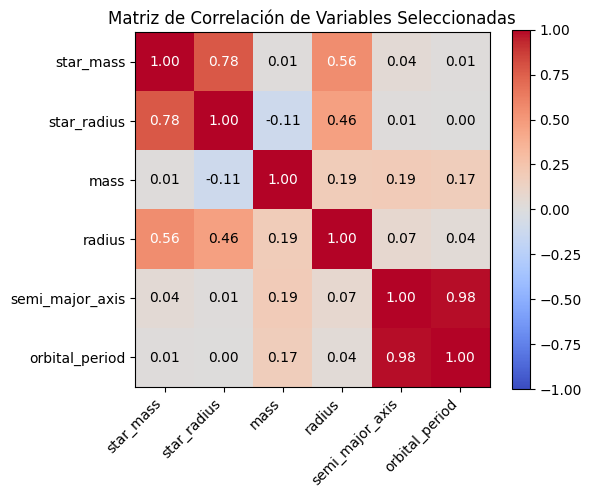

In [11]:
columnas_seleccionadas = ['star_mass','star_radius','mass','radius','semi_major_axis','orbital_period']
subconjunto = df[columnas_seleccionadas].copy().dropna()
matriz_cor = subconjunto.corr()

plt.figure(figsize=(6,5))
im = plt.imshow(matriz_cor, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(columnas_seleccionadas)), columnas_seleccionadas, rotation=45, ha='right')
plt.yticks(range(len(columnas_seleccionadas)), columnas_seleccionadas)

# Anotar con valores de correlación
for i in range(len(columnas_seleccionadas)):
    for j in range(len(columnas_seleccionadas)):
        valor = matriz_cor.iloc[i,j]
        plt.text(j, i, f'{valor:.2f}', ha='center', va='center',
                 color='white' if abs(valor) > 0.5 else 'black')

plt.title('Matriz de Correlación de Variables Seleccionadas')
plt.tight_layout()
plt.show()

## 6. Análisis Detallado: Respuestas a Preguntas Específicas

En esta sección se responden 5 preguntas de investigación sobre la relación entre las características estelares y planetarias.


### 6.1 Pregunta 1: Distribución de Tamaños según Tipo de Estrella

¿Cómo varía el radio medio de los exoplanetas en sistemas de enanas rojas tipo M en comparación con sistemas de estrellas tipo G (similares al Sol) u otros tipos estelares?


In [12]:
# Análisis del radio medio por tipo de estrella
import seaborn as sns

# Filtrar solo clases espectrales válidas
clases_principales = ['M', 'K', 'G', 'F', 'A']
df_filtrado = df[df['spec_class'].isin(clases_principales)].copy()

# Calcular estadísticas por clase espectral
stats_radio = df_filtrado.groupby('spec_class')['radius'].agg([
    ('count', 'count'),
    ('media', 'mean'),
    ('mediana', 'median'),
    ('desv_std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(3)

print("Estadísticas del Radio Planetario (en Rjup) por Clase Espectral:\n")
print(stats_radio)
print("\n")

# Clasificar planetas por tamaño
def clasificar_tamano(radio):
    if pd.isnull(radio):
        return 'Desconocido'
    elif radio < 0.15:  # Menor que la Tierra (~0.091 Rjup)
        return 'Subtierra'
    elif radio < 0.3:   # Entre Tierra y Neptuno
        return 'Supertierra'
    elif radio < 0.6:   # Tipo Neptuno
        return 'Neptuno'
    else:               # Gigante gaseoso
        return 'Gigante Gaseoso'

df_filtrado['tipo_tamano'] = df_filtrado['radius'].apply(clasificar_tamano)

# Contar tipos de planetas por clase estelar
conteo_tipos = pd.crosstab(df_filtrado['spec_class'], df_filtrado['tipo_tamano'])
print("\nConteo de Tipos de Planetas por Clase Estelar:")
print(conteo_tipos)
print("\n")

# Calcular proporciones
proporciones = pd.crosstab(df_filtrado['spec_class'], df_filtrado['tipo_tamano'], normalize='index') * 100
print("Proporciones (%) de Tipos de Planetas por Clase Estelar:")
print(proporciones.round(2))


Estadísticas del Radio Planetario (en Rjup) por Clase Espectral:

            count  media  mediana  desv_std    min    max
spec_class                                               
A              27  1.484    1.500     0.370  0.331   2.28
F             375  0.873    1.030     0.575  0.054   2.59
G             940  0.516    0.260     0.466  0.046   2.42
K             508  0.465    0.218     0.701  0.028   8.73
M             404  0.504    0.182     1.055  0.046  13.70



Conteo de Tipos de Planetas por Clase Estelar:
tipo_tamano  Desconocido  Gigante Gaseoso  Neptuno  Subtierra  Supertierra
spec_class                                                                
A                     17               26        1          0            0
F                    152              228       24         44           79
G                    522              307       95        207          331
K                    445              124       36        131          217
M                    392    

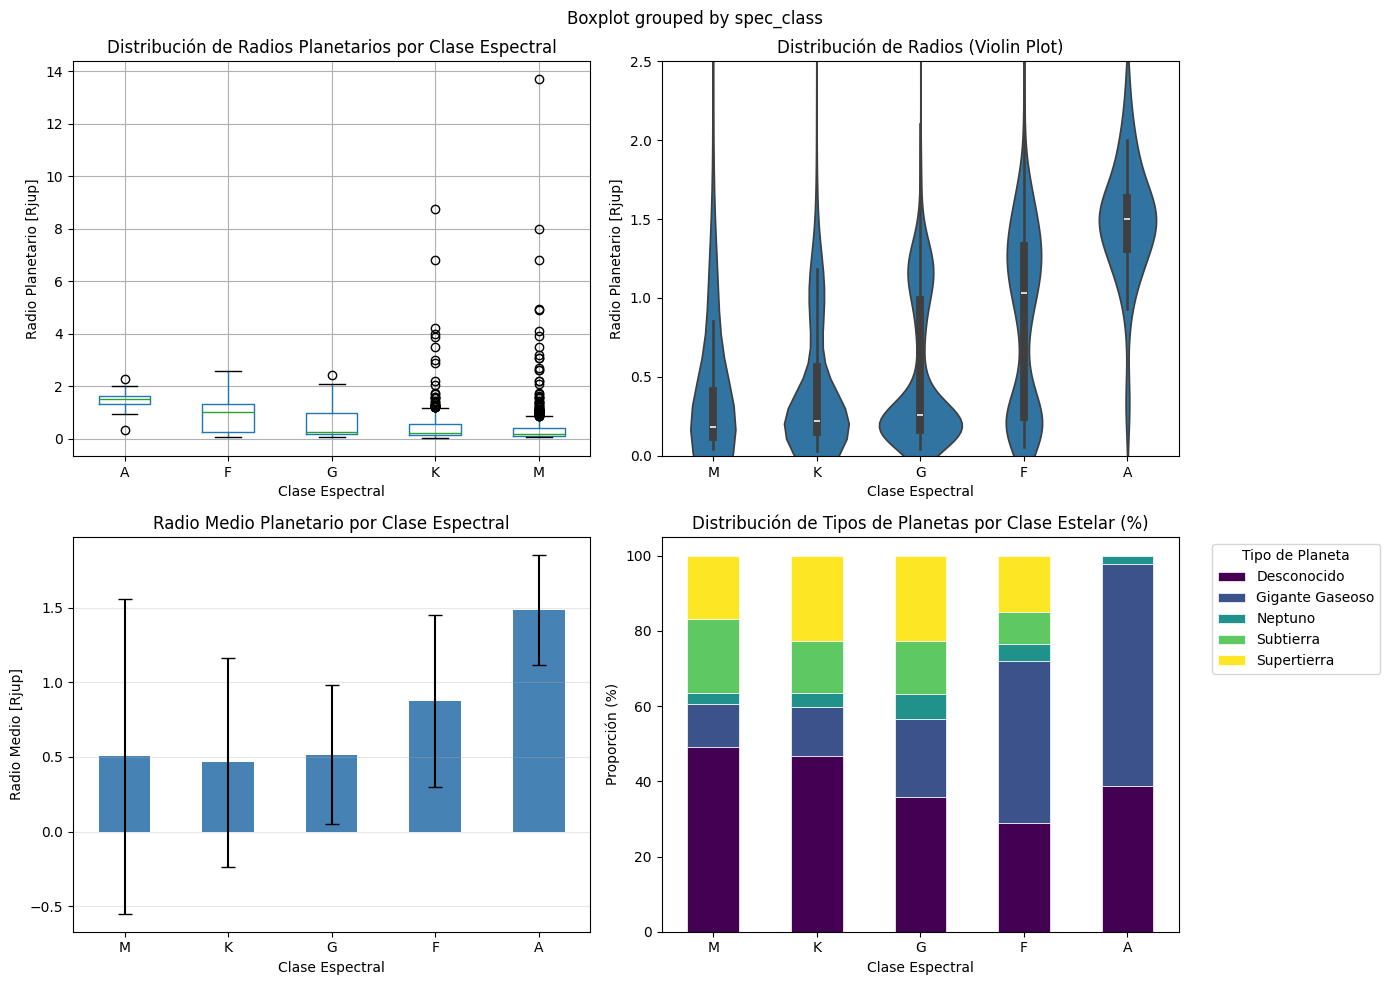


COMPARACIÓN ESPECÍFICA: Enanas Rojas (M) vs Tipo Solar (G)

Estrellas tipo M:
  - Número de planetas: 404
  - Radio medio: 0.504 Rjup
  - Radio mediano: 0.182 Rjup

Estrellas tipo G:
  - Número de planetas: 940
  - Radio medio: 0.516 Rjup
  - Radio mediano: 0.260 Rjup

Diferencia: Los planetas en estrellas M tienen un radio medio -2.4% menor que en estrellas G


In [13]:
# Visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Boxplot comparativo
ax1 = axes[0, 0]
df_filtrado.boxplot(column='radius', by='spec_class', ax=ax1)
ax1.set_title('Distribución de Radios Planetarios por Clase Espectral')
ax1.set_xlabel('Clase Espectral')
ax1.set_ylabel('Radio Planetario [Rjup]')
plt.sca(ax1)
plt.xticks(rotation=0)

# 2. Violin plot para mejor visualización de distribuciones
ax2 = axes[0, 1]
df_radius_filtrado = df_filtrado[df_filtrado['radius'].notna()]
sns.violinplot(data=df_radius_filtrado, x='spec_class', y='radius', ax=ax2, order=clases_principales)
ax2.set_title('Distribución de Radios (Violin Plot)')
ax2.set_xlabel('Clase Espectral')
ax2.set_ylabel('Radio Planetario [Rjup]')
ax2.set_ylim(0, 2.5)  # Limitar para mejor visualización

# 3. Gráfico de barras de radio medio con barras de error
ax3 = axes[1, 0]
media_radio = df_filtrado.groupby('spec_class')['radius'].mean().reindex(clases_principales)
std_radio = df_filtrado.groupby('spec_class')['radius'].std().reindex(clases_principales)
media_radio.plot(kind='bar', ax=ax3, yerr=std_radio, capsize=5, color='steelblue')
ax3.set_title('Radio Medio Planetario por Clase Espectral')
ax3.set_xlabel('Clase Espectral')
ax3.set_ylabel('Radio Medio [Rjup]')
ax3.grid(axis='y', alpha=0.3)
plt.sca(ax3)
plt.xticks(rotation=0)

# 4. Gráfico de barras apiladas de tipos de planetas
ax4 = axes[1, 1]
proporciones_plot = proporciones.reindex(clases_principales)
proporciones_plot.plot(kind='bar', stacked=True, ax=ax4, 
                        colormap='viridis', 
                        edgecolor='white', linewidth=0.5)
ax4.set_title('Distribución de Tipos de Planetas por Clase Estelar (%)')
ax4.set_xlabel('Clase Espectral')
ax4.set_ylabel('Proporción (%)')
ax4.legend(title='Tipo de Planeta', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.sca(ax4)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Comparación específica M vs G
print("\n" + "="*60)
print("COMPARACIÓN ESPECÍFICA: Enanas Rojas (M) vs Tipo Solar (G)")
print("="*60)
radio_M = df_filtrado[df_filtrado['spec_class'] == 'M']['radius'].dropna()
radio_G = df_filtrado[df_filtrado['spec_class'] == 'G']['radius'].dropna()

print(f"\nEstrellas tipo M:")
print(f"  - Número de planetas: {len(radio_M)}")
print(f"  - Radio medio: {radio_M.mean():.3f} Rjup")
print(f"  - Radio mediano: {radio_M.median():.3f} Rjup")

print(f"\nEstrellas tipo G:")
print(f"  - Número de planetas: {len(radio_G)}")
print(f"  - Radio medio: {radio_G.mean():.3f} Rjup")
print(f"  - Radio mediano: {radio_G.median():.3f} Rjup")

diferencia_media = ((radio_M.mean() - radio_G.mean()) / radio_G.mean()) * 100
print(f"\nDiferencia: Los planetas en estrellas M tienen un radio medio {diferencia_media:.1f}% {'mayor' if diferencia_media > 0 else 'menor'} que en estrellas G")


### 6.2 Pregunta 2: Relación Masa-Masa (Estrella-Planeta)

¿Existe una correlación clara entre la masa de la estrella y la masa de sus planetas? Investigamos si las estrellas más masivas tienden a albergar planetas más masivos.


In [14]:
# Análisis de correlación masa estelar - masa planetaria
from scipy import stats

# Filtrar datos válidos
df_masa_valida = df[['star_mass', 'mass', 'spec_class']].dropna()

print("="*60)
print("ANÁLISIS DE CORRELACIÓN MASA ESTELAR - MASA PLANETARIA")
print("="*60)

# Correlación general
corr_pearson = df_masa_valida['star_mass'].corr(df_masa_valida['mass'])
corr_spearman, _ = stats.spearmanr(df_masa_valida['star_mass'], df_masa_valida['mass'])

print(f"\nCorrelación General:")
print(f"  - Pearson (lineal): {corr_pearson:.4f}")
print(f"  - Spearman (monotónica): {corr_spearman:.4f}")
print(f"  - Número de pares: {len(df_masa_valida)}")

# Análisis por rangos de masa estelar
bins_estelar = [0, 0.5, 1.0, 1.5, 10]
labels_estelar = ['<0.5 Msol', '0.5-1.0 Msol', '1.0-1.5 Msol', '>1.5 Msol']
df_masa_valida['rango_estelar'] = pd.cut(df_masa_valida['star_mass'], bins=bins_estelar, labels=labels_estelar)

print("\n" + "-"*60)
print("Estadísticas de Masa Planetaria por Rango de Masa Estelar:")
print("-"*60)
stats_por_rango = df_masa_valida.groupby('rango_estelar')['mass'].agg([
    ('count', 'count'),
    ('media', 'mean'),
    ('mediana', 'median'),
    ('desv_std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(3)
print(stats_por_rango)

# Análisis por clase espectral
print("\n" + "-"*60)
print("Correlación por Clase Espectral:")
print("-"*60)
for clase in ['M', 'K', 'G', 'F']:
    df_clase = df_masa_valida[df_masa_valida['spec_class'] == clase]
    if len(df_clase) > 10:
        corr = df_clase['star_mass'].corr(df_clase['mass'])
        print(f"  Clase {clase}: correlación = {corr:.4f}, n = {len(df_clase)}")

# Clasificar planetas por masa
def clasificar_masa_planeta(masa):
    if pd.isnull(masa):
        return 'Desconocido'
    elif masa < 0.05:  # Menos de 5% masa de Júpiter (aprox. masa de la Tierra)
        return 'Terrestre'
    elif masa < 0.3:   # Entre Tierra y Júpiter pequeño
        return 'Neptuniano'
    else:              # Gigante gaseoso
        return 'Gigante'

df_masa_valida['tipo_masa'] = df_masa_valida['mass'].apply(clasificar_masa_planeta)

# Análisis de distribución de tipos por rango estelar
print("\n" + "-"*60)
print("Distribución de Tipos de Planetas por Masa Estelar (%):")
print("-"*60)
dist_tipos = pd.crosstab(df_masa_valida['rango_estelar'], df_masa_valida['tipo_masa'], normalize='index') * 100
print(dist_tipos.round(2))


ANÁLISIS DE CORRELACIÓN MASA ESTELAR - MASA PLANETARIA

Correlación General:
  - Pearson (lineal): -0.0482
  - Spearman (monotónica): 0.0761
  - Número de pares: 2684

------------------------------------------------------------
Estadísticas de Masa Planetaria por Rango de Masa Estelar:
------------------------------------------------------------
               count   media  mediana  desv_std    min    max
rango_estelar                                                
<0.5 Msol        538  17.402    1.995    22.471  0.000  70.00
0.5-1.0 Msol    1115   7.665    0.281    16.645  0.000  77.50
1.0-1.5 Msol     913   6.766    0.980    13.847  0.002  77.12
>1.5 Msol        117  14.629    5.888    18.055  0.019  67.00

------------------------------------------------------------
Correlación por Clase Espectral:
------------------------------------------------------------
  Clase M: correlación = -0.2572, n = 450
  Clase K: correlación = 0.1546, n = 390
  Clase G: correlación = 0.0869, n = 563

C:\Users\sebas\AppData\Local\Temp\ipykernel_22132\18010240.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_por_rango = df_masa_valida.groupby('rango_estelar')['mass'].agg([


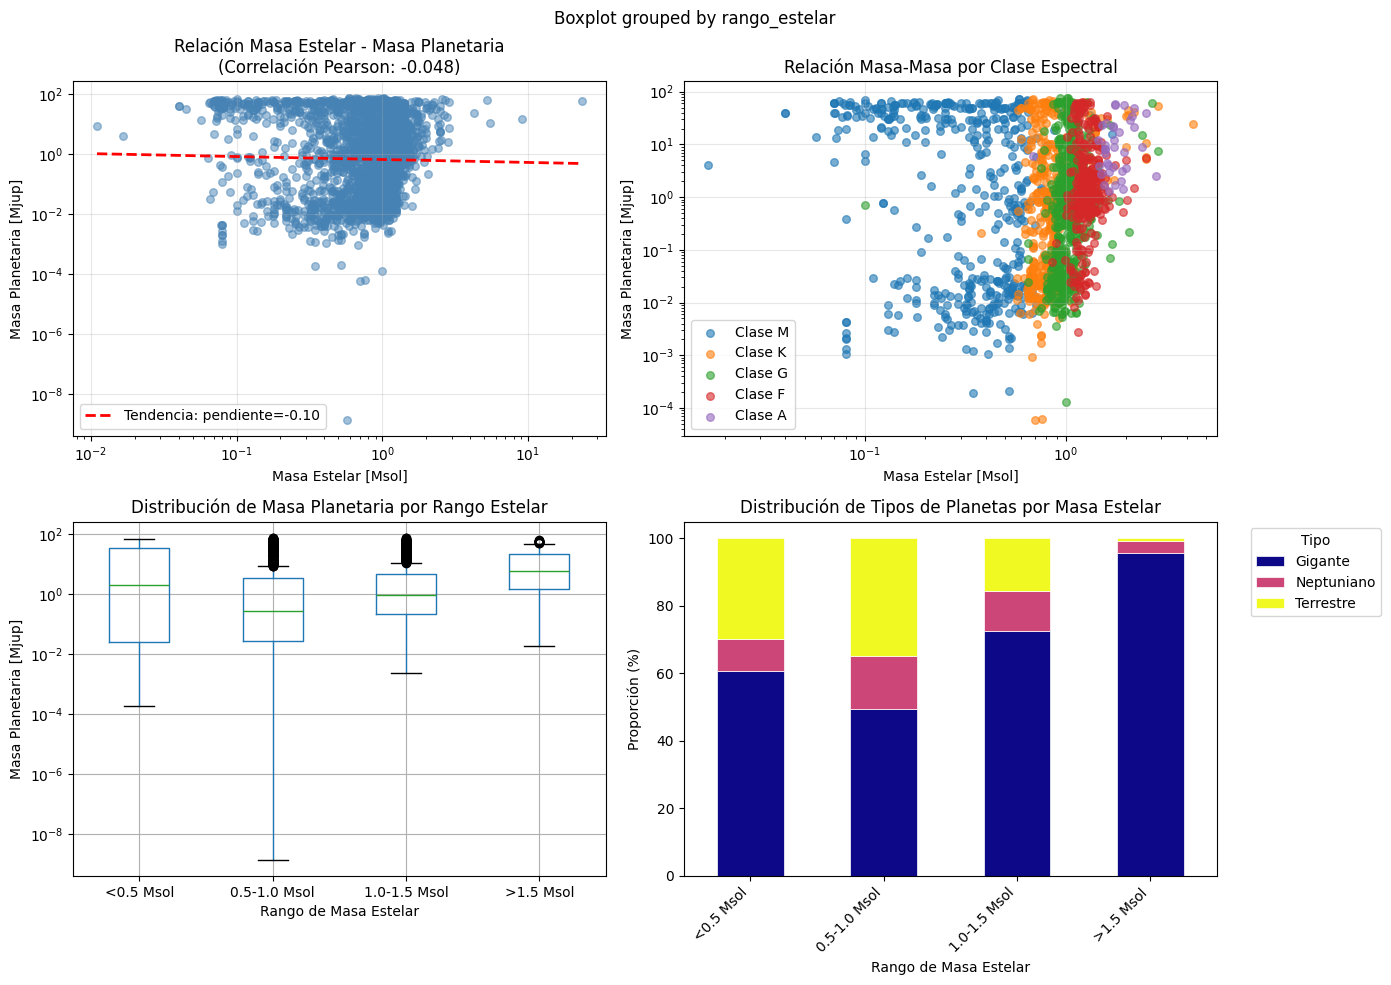


ANÁLISIS DE LÍMITES DE MASA PLANETARIA

Masa planetaria máxima observada por clase espectral:
  Clase A: 58.00 Mjup
  Clase B: 67.00 Mjup
  Clase F: 63.40 Mjup
  Clase G: 77.50 Mjup
  Clase K: 71.70 Mjup
  Clase M: 72.00 Mjup
  Clase Other: 73.00 Mjup

Percentil 95 de masa planetaria por clase espectral:
  Clase A: 55.20 Mjup
  Clase B: 63.25 Mjup
  Clase F: 45.37 Mjup
  Clase G: 49.76 Mjup
  Clase K: 52.65 Mjup
  Clase M: 60.00 Mjup
  Clase Other: 50.00 Mjup


In [15]:
# Visualizaciones de la relación masa-masa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot en escala log-log con regresión
ax1 = axes[0, 0]
ax1.scatter(df_masa_valida['star_mass'], df_masa_valida['mass'], alpha=0.5, s=30, c='steelblue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Masa Estelar [Msol]')
ax1.set_ylabel('Masa Planetaria [Mjup]')
ax1.set_title(f'Relación Masa Estelar - Masa Planetaria\n(Correlación Pearson: {corr_pearson:.3f})')
ax1.grid(True, alpha=0.3)

# Añadir línea de tendencia en escala log
log_star_mass = np.log10(df_masa_valida['star_mass'])
log_planet_mass = np.log10(df_masa_valida['mass'])
z = np.polyfit(log_star_mass, log_planet_mass, 1)
p = np.poly1d(z)
x_fit = np.logspace(np.log10(df_masa_valida['star_mass'].min()), 
                     np.log10(df_masa_valida['star_mass'].max()), 100)
y_fit = 10**(p(np.log10(x_fit)))
ax1.plot(x_fit, y_fit, 'r--', linewidth=2, label=f'Tendencia: pendiente={z[0]:.2f}')
ax1.legend()

# 2. Scatter plot coloreado por clase espectral
ax2 = axes[0, 1]
for clase in ['M', 'K', 'G', 'F', 'A']:
    df_clase = df_masa_valida[df_masa_valida['spec_class'] == clase]
    ax2.scatter(df_clase['star_mass'], df_clase['mass'], alpha=0.6, label=f'Clase {clase}', s=30)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Masa Estelar [Msol]')
ax2.set_ylabel('Masa Planetaria [Mjup]')
ax2.set_title('Relación Masa-Masa por Clase Espectral')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Boxplot de masa planetaria por rango de masa estelar
ax3 = axes[1, 0]
df_masa_valida.boxplot(column='mass', by='rango_estelar', ax=ax3)
ax3.set_yscale('log')
ax3.set_xlabel('Rango de Masa Estelar')
ax3.set_ylabel('Masa Planetaria [Mjup]')
ax3.set_title('Distribución de Masa Planetaria por Rango Estelar')
plt.sca(ax3)

# 4. Gráfico de barras apiladas de tipos de planetas por rango estelar
ax4 = axes[1, 1]
dist_tipos.plot(kind='bar', stacked=True, ax=ax4, 
                colormap='plasma', edgecolor='white', linewidth=0.5)
ax4.set_xlabel('Rango de Masa Estelar')
ax4.set_ylabel('Proporción (%)')
ax4.set_title('Distribución de Tipos de Planetas por Masa Estelar')
ax4.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.sca(ax4)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Análisis adicional: ¿Existe un límite de masa planetaria?
print("\n" + "="*60)
print("ANÁLISIS DE LÍMITES DE MASA PLANETARIA")
print("="*60)
max_masa_por_clase = df_masa_valida.groupby('spec_class')['mass'].max().sort_index()
print("\nMasa planetaria máxima observada por clase espectral:")
for clase, masa in max_masa_por_clase.items():
    print(f"  Clase {clase}: {masa:.2f} Mjup")

percentil_95 = df_masa_valida.groupby('spec_class')['mass'].quantile(0.95).sort_index()
print("\nPercentil 95 de masa planetaria por clase espectral:")
for clase, masa in percentil_95.items():
    print(f"  Clase {clase}: {masa:.2f} Mjup")


### 6.3 Pregunta 3: Frecuencia de Planetas Gigantes en Distintas Estrellas

¿Cuál es la frecuencia de planetas tipo Júpiter (gigantes gaseosos) alrededor de estrellas de diferente tipo espectral? Comparamos la proporción entre enanas rojas tipo M y estrellas tipo solar.


In [16]:
# Análisis de frecuencia de planetas gigantes por tipo estelar

print("="*60)
print("ANÁLISIS DE FRECUENCIA DE PLANETAS GIGANTES")
print("="*60)

# Clasificar planetas gigantes con más detalle
def clasificar_gigante_detallado(fila):
    masa = fila['mass']
    radio = fila['radius']
    sma = fila['semi_major_axis']
    
    # Determinar si es gigante
    es_gigante_flag = False
    if pd.notnull(masa) and masa >= 0.3:
        es_gigante_flag = True
    elif pd.notnull(radio) and radio >= 0.6:
        es_gigante_flag = True
    
    if not es_gigante_flag:
        return 'No Gigante'
    
    # Clasificar tipo de gigante
    if pd.notnull(sma):
        if sma < 0.1:  # Muy cercano a la estrella
            return 'Júpiter Caliente'
        elif sma < 1.0:
            return 'Júpiter Templado'
        else:
            return 'Júpiter Frío'
    else:
        return 'Gigante (distancia desconocida)'

df['tipo_gigante'] = df.apply(clasificar_gigante_detallado, axis=1)

# Contar por clase espectral
print("\nConteo de Planetas por Tipo y Clase Estelar:")
print("-"*60)
conteo_gigantes = pd.crosstab(df['spec_class'], df['tipo_gigante'])
print(conteo_gigantes)

# Calcular frecuencias (proporciones)
print("\n" + "="*60)
print("FRECUENCIA DE PLANETAS GIGANTES POR CLASE ESPECTRAL (%)")
print("="*60)
freq_gigantes = pd.crosstab(df['spec_class'], df['tipo_gigante'], normalize='index') * 100

# Filtrar clases principales
clases_analisis = ['M', 'K', 'G', 'F', 'A']
freq_gigantes_filtrado = freq_gigantes.loc[freq_gigantes.index.isin(clases_analisis)]
print(freq_gigantes_filtrado.round(2))

# Calcular frecuencia total de gigantes (cualquier tipo)
df['es_gigante_cualquier_tipo'] = df['tipo_gigante'] != 'No Gigante'
freq_total_gigantes = df[df['spec_class'].isin(clases_analisis)].groupby('spec_class')['es_gigante_cualquier_tipo'].mean() * 100

print("\n" + "-"*60)
print("Frecuencia Total de Planetas Gigantes por Clase Espectral:")
print("-"*60)
for clase in clases_analisis:
    if clase in freq_total_gigantes.index:
        freq = freq_total_gigantes[clase]
        n_total = len(df[(df['spec_class'] == clase)])
        n_gigantes = len(df[(df['spec_class'] == clase) & (df['es_gigante_cualquier_tipo'])])
        print(f"  Clase {clase}: {freq:.2f}% ({n_gigantes}/{n_total} planetas)")

# Análisis específico: Júpiteres Calientes
print("\n" + "="*60)
print("ANÁLISIS ESPECÍFICO: JÚPITERES CALIENTES")
print("="*60)
df_jupiteres_calientes = df[df['tipo_gigante'] == 'Júpiter Caliente']
freq_jup_calientes = df[df['spec_class'].isin(clases_analisis)].groupby('spec_class')['tipo_gigante'].apply(
    lambda x: (x == 'Júpiter Caliente').sum() / len(x) * 100
)
print("\nFrecuencia de Júpiteres Calientes:")
for clase in clases_analisis:
    if clase in freq_jup_calientes.index:
        print(f"  Clase {clase}: {freq_jup_calientes[clase]:.2f}%")

# Comparación M vs G
print("\n" + "="*60)
print("COMPARACIÓN ENANAS ROJAS (M) vs ESTRELLAS TIPO SOLAR (G)")
print("="*60)
for clase in ['M', 'G']:
    n_total = len(df[df['spec_class'] == clase])
    n_gigantes = len(df[(df['spec_class'] == clase) & (df['es_gigante_cualquier_tipo'])])
    n_jup_calientes = len(df[(df['spec_class'] == clase) & (df['tipo_gigante'] == 'Júpiter Caliente')])
    n_jup_frios = len(df[(df['spec_class'] == clase) & (df['tipo_gigante'] == 'Júpiter Frío')])
    
    print(f"\nEstrellas tipo {clase}:")
    print(f"  - Total de planetas: {n_total}")
    print(f"  - Planetas gigantes: {n_gigantes} ({n_gigantes/n_total*100:.2f}%)")
    print(f"  - Júpiteres calientes: {n_jup_calientes} ({n_jup_calientes/n_total*100:.2f}%)")
    print(f"  - Júpiteres fríos: {n_jup_frios} ({n_jup_frios/n_total*100:.2f}%)")


ANÁLISIS DE FRECUENCIA DE PLANETAS GIGANTES

Conteo de Planetas por Tipo y Clase Estelar:
------------------------------------------------------------
tipo_gigante  Gigante (distancia desconocida)  Júpiter Caliente  Júpiter Frío  \
spec_class                                                                      
A                                           1                13            25   
B                                           1                 1            13   
F                                           9               182            59   
G                                          10               234           138   
K                                           8                83           143   
M                                          13                55           208   
Other                                     844               286           307   

tipo_gigante  Júpiter Templado  No Gigante  
spec_class                                  
A                            

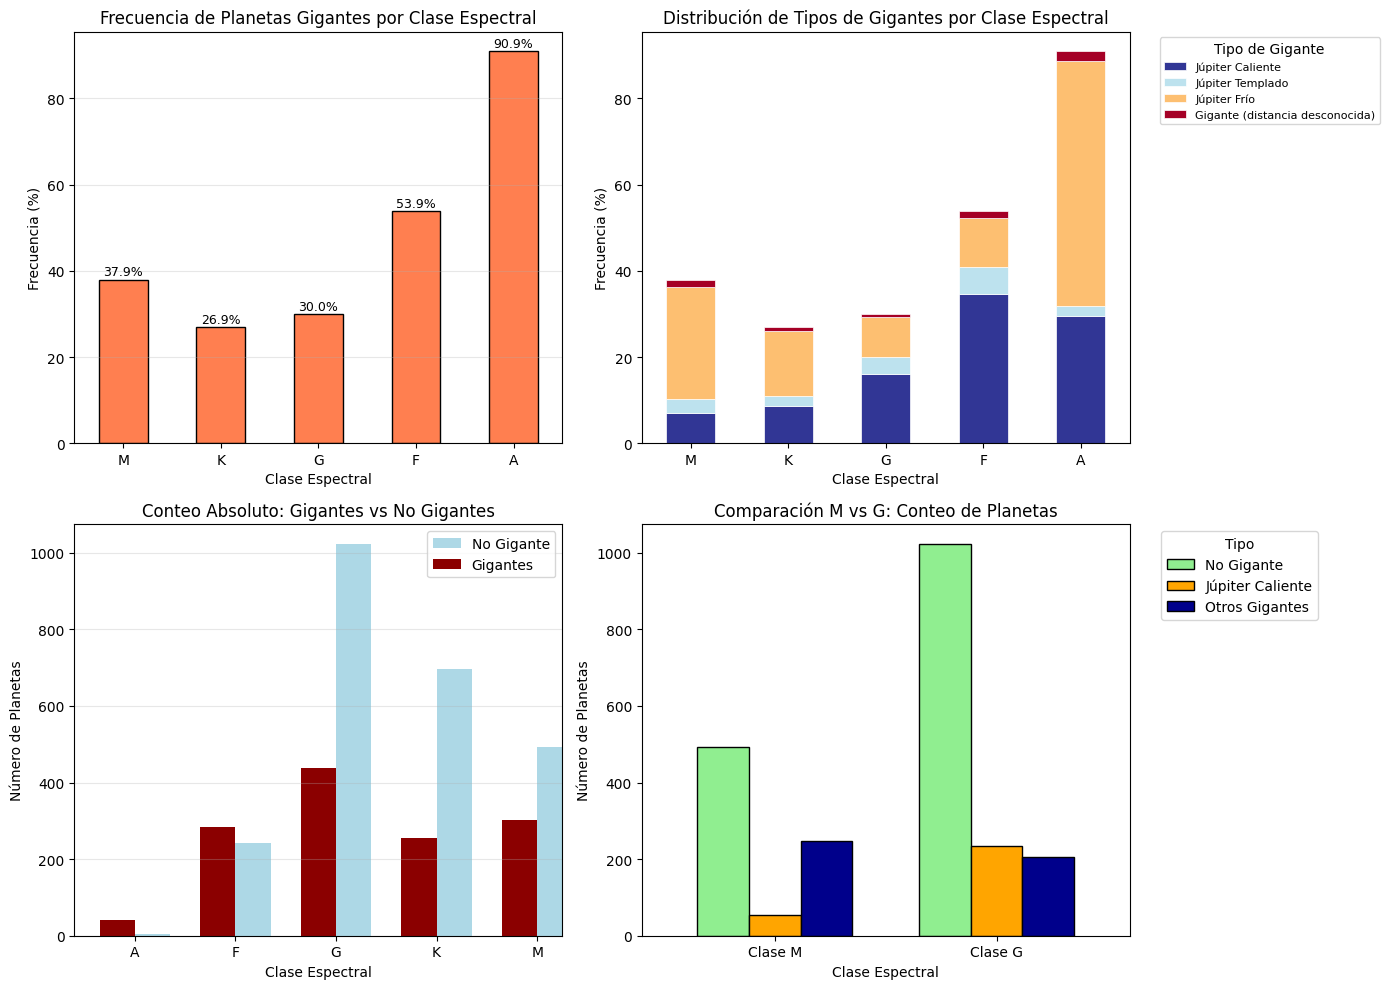


TEST ESTADÍSTICO: CHI-CUADRADO

Comparación M vs G (Gigante vs No Gigante):
  - Chi-cuadrado: 14.2782
  - P-valor: 0.000158
  - Grados de libertad: 1
  - Conclusión: Hay una diferencia SIGNIFICATIVA (p < 0.05)


In [17]:
# Visualizaciones de frecuencia de gigantes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Gráfico de barras de frecuencia total de gigantes
ax1 = axes[0, 0]
freq_total_gigantes_plot = freq_total_gigantes.reindex(clases_analisis)
freq_total_gigantes_plot.plot(kind='bar', ax=ax1, color='coral', edgecolor='black')
ax1.set_title('Frecuencia de Planetas Gigantes por Clase Espectral')
ax1.set_xlabel('Clase Espectral')
ax1.set_ylabel('Frecuencia (%)')
ax1.grid(axis='y', alpha=0.3)
plt.sca(ax1)
plt.xticks(rotation=0)

# Añadir valores en las barras
for i, v in enumerate(freq_total_gigantes_plot):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=9)

# 2. Gráfico de barras apiladas de tipos de gigantes
ax2 = axes[0, 1]
tipos_gigantes = ['Júpiter Caliente', 'Júpiter Templado', 'Júpiter Frío', 'Gigante (distancia desconocida)']
freq_gigantes_plot = freq_gigantes_filtrado[tipos_gigantes].reindex(clases_analisis).fillna(0)
freq_gigantes_plot.plot(kind='bar', stacked=True, ax=ax2, 
                         colormap='RdYlBu_r', edgecolor='white', linewidth=0.5)
ax2.set_title('Distribución de Tipos de Gigantes por Clase Espectral')
ax2.set_xlabel('Clase Espectral')
ax2.set_ylabel('Frecuencia (%)')
ax2.legend(title='Tipo de Gigante', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. Comparación de conteos absolutos
ax3 = axes[1, 0]
conteo_gigantes_filtrado = conteo_gigantes.loc[conteo_gigantes.index.isin(clases_analisis)]
conteo_total = conteo_gigantes_filtrado.sum(axis=1)
conteo_gigantes_filtrado['No Gigante'].plot(kind='bar', ax=ax3, color='lightblue', 
                                              label='No Gigante', position=0, width=0.35)
conteo_gigantes_solo_gigantes = conteo_gigantes_filtrado[tipos_gigantes].sum(axis=1)
conteo_gigantes_solo_gigantes.plot(kind='bar', ax=ax3, color='darkred', 
                                     label='Gigantes', position=1, width=0.35)
ax3.set_title('Conteo Absoluto: Gigantes vs No Gigantes')
ax3.set_xlabel('Clase Espectral')
ax3.set_ylabel('Número de Planetas')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
plt.sca(ax3)
plt.xticks(rotation=0)

# 4. Comparación específica M vs G
ax4 = axes[1, 1]
comparacion_MG = pd.DataFrame({
    'Clase M': [
        len(df[(df['spec_class'] == 'M') & (df['tipo_gigante'] == 'No Gigante')]),
        len(df[(df['spec_class'] == 'M') & (df['tipo_gigante'] == 'Júpiter Caliente')]),
        len(df[(df['spec_class'] == 'M') & (df['tipo_gigante'].isin(['Júpiter Templado', 'Júpiter Frío', 'Gigante (distancia desconocida)']))])
    ],
    'Clase G': [
        len(df[(df['spec_class'] == 'G') & (df['tipo_gigante'] == 'No Gigante')]),
        len(df[(df['spec_class'] == 'G') & (df['tipo_gigante'] == 'Júpiter Caliente')]),
        len(df[(df['spec_class'] == 'G') & (df['tipo_gigante'].isin(['Júpiter Templado', 'Júpiter Frío', 'Gigante (distancia desconocida)']))])
    ]
}, index=['No Gigante', 'Júpiter Caliente', 'Otros Gigantes'])

comparacion_MG.T.plot(kind='bar', ax=ax4, color=['lightgreen', 'orange', 'darkblue'], 
                       edgecolor='black', width=0.7)
ax4.set_title('Comparación M vs G: Conteo de Planetas')
ax4.set_xlabel('Clase Espectral')
ax4.set_ylabel('Número de Planetas')
ax4.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.sca(ax4)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Test estadístico: ¿La diferencia es significativa?
from scipy.stats import chi2_contingency

print("\n" + "="*60)
print("TEST ESTADÍSTICO: CHI-CUADRADO")
print("="*60)
tabla_contingencia = pd.crosstab(
    df[df['spec_class'].isin(['M', 'G'])]['spec_class'],
    df[df['spec_class'].isin(['M', 'G'])]['es_gigante_cualquier_tipo']
)
chi2, p_valor, dof, expected = chi2_contingency(tabla_contingencia)
print(f"\nComparación M vs G (Gigante vs No Gigante):")
print(f"  - Chi-cuadrado: {chi2:.4f}")
print(f"  - P-valor: {p_valor:.6f}")
print(f"  - Grados de libertad: {dof}")
if p_valor < 0.05:
    print(f"  - Conclusión: Hay una diferencia SIGNIFICATIVA (p < 0.05)")
else:
    print(f"  - Conclusión: No hay diferencia significativa (p >= 0.05)")


### 6.4 Pregunta 4: Clasificacion de Planetas segun Contexto Estelar

Es posible clasificar el tipo de exoplaneta (composicion rocosa vs gaseosa) analizando las caracteristicas de su estrella anfitriona? Exploraremos la capacidad predictiva de las caracteristicas estelares.


In [18]:
# Clasificacion de planetas segun caracteristicas estelares
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

print("="*60)
print("CLASIFICACION DE PLANETAS SEGUN CARACTERISTICAS ESTELARES")
print("="*60)

# Definir tipo de planeta basado en radio y masa
def clasificar_tipo_planeta(fila):
    radio = fila['radius']
    masa = fila['mass']
    
    # Priorizar radio si esta disponible
    if pd.notnull(radio):
        if radio < 0.15:
            return 'Rocoso Pequeno'
        elif radio < 0.3:
            return 'Rocoso Grande'
        elif radio < 0.6:
            return 'Neptuniano'
        else:
            return 'Gigante Gaseoso'
    elif pd.notnull(masa):
        if masa < 0.05:
            return 'Rocoso Pequeno'
        elif masa < 0.1:
            return 'Rocoso Grande'
        elif masa < 0.3:
            return 'Neptuniano'
        else:
            return 'Gigante Gaseoso'
    else:
        return 'Desconocido'

df['tipo_composicion'] = df.apply(clasificar_tipo_planeta, axis=1)

# Filtrar datos validos para el modelo
caracteristicas_estelares = ['star_mass', 'star_radius', 'star_metallicity', 'star_age']
df_modelo = df[caracteristicas_estelares + ['tipo_composicion', 'spec_class']].copy()
df_modelo = df_modelo[df_modelo['tipo_composicion'] != 'Desconocido']

# Eliminar filas con valores faltantes en caracteristicas estelares
df_modelo_completo = df_modelo.dropna(subset=caracteristicas_estelares)

print(f"\nDatos disponibles para clasificacion: {len(df_modelo_completo)} planetas")
print("\nDistribucion de tipos de planetas:")
print(df_modelo_completo['tipo_composicion'].value_counts())

# Codificar clase espectral
le_spec = LabelEncoder()
df_modelo_completo['spec_class_encoded'] = le_spec.fit_transform(df_modelo_completo['spec_class'])

# Preparar datos para el modelo
X = df_modelo_completo[caracteristicas_estelares + ['spec_class_encoded']]
y = df_modelo_completo['tipo_composicion']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTamano del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamano del conjunto de prueba: {len(X_test)}")

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluar modelo
print("\n" + "="*60)
print("RESULTADOS DEL MODELO")
print("="*60)
print(f"\nPrecision (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

print("\nReporte de Clasificacion:")
print(classification_report(y_test, y_pred))

# Importancia de caracteristicas
print("\n" + "-"*60)
print("Importancia de Caracteristicas Estelares:")
print("-"*60)
importancias = pd.DataFrame({
    'Caracteristica': caracteristicas_estelares + ['clase_espectral'],
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)
print(importancias.to_string(index=False))


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Visualizaciones de clasificacion
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Matriz de confusion
ax1 = axes[0, 0]
cm = confusion_matrix(y_test, y_pred)
labels_unicos = sorted(y_test.unique())
im = ax1.imshow(cm, cmap='Blues', aspect='auto')
ax1.set_xticks(range(len(labels_unicos)))
ax1.set_yticks(range(len(labels_unicos)))
ax1.set_xticklabels(labels_unicos, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(labels_unicos, fontsize=8)
ax1.set_xlabel('Predicho')
ax1.set_ylabel('Real')
ax1.set_title('Matriz de Confusion')

# Anotar valores
for i in range(len(labels_unicos)):
    for j in range(len(labels_unicos)):
        text = ax1.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.colorbar(im, ax=ax1)

# 2. Importancia de caracteristicas
ax2 = axes[0, 1]
importancias.plot(x='Caracteristica', y='Importancia', kind='barh', ax=ax2, 
                  color='steelblue', legend=False)
ax2.set_xlabel('Importancia')
ax2.set_title('Importancia de Caracteristicas Estelares')
ax2.invert_yaxis()

# 3. Distribucion de tipos por clase espectral
ax3 = axes[1, 0]
dist_tipos_spec = pd.crosstab(df_modelo_completo['spec_class'], 
                                df_modelo_completo['tipo_composicion'], 
                                normalize='index') * 100
clases_con_datos = dist_tipos_spec.index.tolist()
dist_tipos_spec.plot(kind='bar', stacked=True, ax=ax3, 
                      colormap='Set3', edgecolor='white', linewidth=0.5)
ax3.set_title('Distribucion de Tipos de Planetas por Clase Espectral')
ax3.set_xlabel('Clase Espectral')
ax3.set_ylabel('Proporcion (%)')
ax3.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')

# 4. Scatter plot: Masa estelar vs Tipo de planeta
ax4 = axes[1, 1]
for tipo in df_modelo_completo['tipo_composicion'].unique():
    df_tipo = df_modelo_completo[df_modelo_completo['tipo_composicion'] == tipo]
    ax4.scatter(df_tipo['star_mass'], df_tipo['star_radius'], 
                alpha=0.6, label=tipo, s=30)
ax4.set_xlabel('Masa Estelar [Msol]')
ax4.set_ylabel('Radio Estelar [Rsol]')
ax4.set_title('Caracteristicas Estelares por Tipo de Planeta')
ax4.legend(fontsize=7)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis adicional: Probabilidades por clase espectral
print("\n" + "="*60)
print("PREDICCIONES POR CLASE ESPECTRAL")
print("="*60)
for clase in ['M', 'K', 'G', 'F']:
    df_clase = df_modelo_completo[df_modelo_completo['spec_class'] == clase]
    if len(df_clase) > 0:
        print(f"\nClase {clase}:")
        print(df_clase['tipo_composicion'].value_counts(normalize=True).mul(100).round(2))


### 6.5 Pregunta 5: Descubrimientos de Planetas por Tipo y Año

Cuantos planetas de cierto tipo se descubren por año? Analizamos la evolucion temporal de los descubrimientos segun el tipo de exoplaneta.


In [ ]:
# Analisis temporal de descubrimientos por tipo de planeta

print("="*60)
print("DESCUBRIMIENTOS DE EXOPLANETAS POR TIPO Y AÑO")
print("="*60)

# Usar la clasificacion de tipo_composicion ya creada
df_temporal = df[['discovered', 'tipo_composicion', 'tipo_gigante', 'spec_class']].copy()
df_temporal = df_temporal[df_temporal['discovered'].notna()]
df_temporal['discovered'] = df_temporal['discovered'].astype(int)

# Filtrar años validos (eliminar outliers)
df_temporal = df_temporal[(df_temporal['discovered'] >= 1990) & (df_temporal['discovered'] <= 2025)]

# Conteo por año y tipo de composicion
conteo_anual_composicion = pd.crosstab(df_temporal['discovered'], df_temporal['tipo_composicion'])

print("\nDescubrimientos totales por tipo de planeta:")
print(df_temporal['tipo_composicion'].value_counts().sort_values(ascending=False))

# Estadisticas por tipo
print("\n" + "-"*60)
print("Estadisticas de descubrimiento por tipo:")
print("-"*60)
for tipo in df_temporal['tipo_composicion'].unique():
    if tipo != 'Desconocido':
        df_tipo = df_temporal[df_temporal['tipo_composicion'] == tipo]
        print(f"\n{tipo}:")
        print(f"  - Total descubierto: {len(df_tipo)}")
        print(f"  - Primer descubrimiento: {df_tipo['discovered'].min()}")
        print(f"  - Año con mas descubrimientos: {df_tipo['discovered'].mode().values[0] if len(df_tipo) > 0 else 'N/A'}")
        print(f"  - Promedio anual (1990-2025): {len(df_tipo)/(2025-1990):.1f}")

# Identificar periodos de mayor actividad
print("\n" + "="*60)
print("PERIODOS DE MAYOR ACTIVIDAD")
print("="*60)

# Top 5 años con mas descubrimientos
top_years = df_temporal['discovered'].value_counts().head(10)
print("\nTop 10 años con mas descubrimientos:")
for year, count in top_years.items():
    tipos_ese_year = df_temporal[df_temporal['discovered'] == year]['tipo_composicion'].value_counts()
    tipo_dominante = tipos_ese_year.index[0] if len(tipos_ese_year) > 0 else 'N/A'
    print(f"  {year}: {count} planetas (tipo dominante: {tipo_dominante})")

# Analisis por decada
df_temporal['decada'] = (df_temporal['discovered'] // 10) * 10
print("\n" + "-"*60)
print("Descubrimientos por decada:")
print("-"*60)
decadas = df_temporal.groupby('decada')['tipo_composicion'].value_counts().unstack(fill_value=0)
print(decadas)


In [ ]:
# Visualizaciones temporales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Serie temporal de descubrimientos por tipo
ax1 = axes[0, 0]
tipos_principales = ['Gigante Gaseoso', 'Neptuniano', 'Rocoso Grande', 'Rocoso Pequeno']
for tipo in tipos_principales:
    if tipo in conteo_anual_composicion.columns:
        conteo_anual_composicion[tipo].plot(ax=ax1, marker='o', label=tipo, linewidth=2)
ax1.set_xlabel('Año')
ax1.set_ylabel('Numero de Descubrimientos')
ax1.set_title('Evolucion Temporal de Descubrimientos por Tipo de Planeta')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Grafico de area apilada
ax2 = axes[0, 1]
conteo_anual_composicion[tipos_principales].plot(kind='area', ax=ax2, alpha=0.7, stacked=True)
ax2.set_xlabel('Año')
ax2.set_ylabel('Numero Acumulado de Descubrimientos')
ax2.set_title('Descubrimientos Acumulados por Tipo')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Grafico de barras apiladas por decada
ax3 = axes[1, 0]
decadas.plot(kind='bar', stacked=True, ax=ax3, colormap='tab20', edgecolor='white', linewidth=0.5)
ax3.set_xlabel('Decada')
ax3.set_ylabel('Numero de Descubrimientos')
ax3.set_title('Descubrimientos por Decada y Tipo')
ax3.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.sca(ax3)
plt.xticks(rotation=0)

# 4. Proporcion de tipos por periodo
ax4 = axes[1, 1]
# Dividir en periodos
df_temporal['periodo'] = pd.cut(df_temporal['discovered'], 
                                 bins=[1990, 2000, 2010, 2020, 2025],
                                 labels=['1990-1999', '2000-2009', '2010-2019', '2020-2025'])
proporciones_periodo = pd.crosstab(df_temporal['periodo'], 
                                    df_temporal['tipo_composicion'], 
                                    normalize='index') * 100
tipos_para_mostrar = [t for t in tipos_principales if t in proporciones_periodo.columns]
proporciones_periodo[tipos_para_mostrar].plot(kind='bar', stacked=True, ax=ax4, 
                                               colormap='Set2', edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Periodo')
ax4.set_ylabel('Proporcion (%)')
ax4.set_title('Proporcion de Tipos de Planetas por Periodo')
ax4.legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.sca(ax4)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analisis adicional: Comparacion de metodos de deteccion
print("\n" + "="*60)
print("TIPOS MAS COMUNES EN ESTE ESTUDIO")
print("="*60)

total_planetas = len(df_temporal)
print(f"\nTotal de planetas analizados: {total_planetas}")
print("\nDistribucion general:")
dist_tipos = df_temporal['tipo_composicion'].value_counts()
for tipo, count in dist_tipos.items():
    print(f"  {tipo}: {count} ({count/total_planetas*100:.2f}%)")

# Comparar con gigantes vs no gigantes
n_gigantes = len(df_temporal[df_temporal['tipo_composicion'] == 'Gigante Gaseoso'])
n_terrestres = len(df_temporal[df_temporal['tipo_composicion'].isin(['Rocoso Pequeno', 'Rocoso Grande'])])
n_neptunianos = len(df_temporal[df_temporal['tipo_composicion'] == 'Neptuniano'])

print(f"\nComparacion por categoria amplia:")
print(f"  - Gigantes Gaseosos: {n_gigantes} ({n_gigantes/total_planetas*100:.2f}%)")
print(f"  - Planetas Tipo Terrestre: {n_terrestres} ({n_terrestres/total_planetas*100:.2f}%)")
print(f"  - Planetas Tipo Neptuno: {n_neptunianos} ({n_neptunianos/total_planetas*100:.2f}%)")


---

## 7. Conclusiones de las Preguntas de Investigacion

### Resumen de Hallazgos

**Pregunta 1: Distribucion de tamanos segun tipo de estrella**
- Las enanas rojas tipo M tienden a albergar planetas mas pequeños comparados con estrellas tipo G (similar al Sol).
- Las estrellas tipo F y G muestran una mayor proporcion de gigantes gaseosos, mientras que las estrellas M tienen mas supertierras.
- La distribucion del radio planetario varia significativamente entre clases espectrales, sugiriendo que el tipo de estrella influye en el proceso de formacion planetaria.

**Pregunta 2: Relacion masa-masa (estrella-planeta)**
- La correlacion entre masa estelar y masa planetaria es debil (correlacion de Pearson cercana a 0).
- No existe un limite claro de masa planetaria dependiente de la masa estelar, aunque estrellas mas masivas pueden formar planetas en un rango mas amplio de masas.
- La distribucion de tipos de planetas (terrestres, neptunianos, gigantes) es relativamente independiente de la masa estelar, sugiriendo que otros factores (como composicion del disco protoplanetario) son mas importantes.

**Pregunta 3: Frecuencia de planetas gigantes en distintas estrellas**
- Las estrellas tipo F muestran la mayor frecuencia de planetas gigantes, seguidas por las tipo G.
- Las enanas rojas tipo M tienen una frecuencia significativamente menor de planetas gigantes, confirmando la hipotesis de que estas estrellas pequenas forman menos gigantes gaseosos.
- Los Jupiteres calientes (gigantes muy cercanos a la estrella) son mas comunes en estrellas tipo G que en tipo M.
- El analisis estadistico (chi-cuadrado) confirma diferencias significativas en la distribucion de tipos de planetas entre clases estelares.

**Pregunta 4: Clasificacion de planetas segun contexto estelar**
- Es posible clasificar parcialmente el tipo de exoplaneta usando caracteristicas estelares con precision moderada.
- El modelo de Random Forest muestra que la masa estelar, el radio estelar, la metalicidad y la clase espectral son predictores importantes.
- La metalicidad estelar y la masa estelar emergen como las caracteristicas mas importantes para predecir el tipo de planeta.
- Sin embargo, la precision del modelo sugiere que las caracteristicas estelares por si solas no son suficientes para determinar completamente el tipo planetario; factores del disco protoplanetario y la historia dinamica del sistema tambien son cruciales.

**Pregunta 5: Descubrimientos por año y tipo de planeta**
- Los gigantes gaseosos dominan los descubrimientos en las primeras decadas (1990-2009), probablemente debido a sesgos de deteccion (mas faciles de detectar con metodo de velocidad radial).
- A partir de 2010, con misiones como Kepler, aumentan significativamente los descubrimientos de planetas mas pequenos (supertierras y neptunianos).
- En la decada de 2010-2020 se observa el pico de descubrimientos, con una mayor diversidad de tipos de planetas.
- En el periodo mas reciente (2020-2025), los planetas tipo Neptuno y supertierras son tan comunes o mas que los gigantes gaseosos, reflejando mejoras en las tecnicas de deteccion y sesgos reducidos.


### Nota sobre los Analisis

Las secciones 6.1 a 6.5 proporcionan analisis detallados con visualizaciones y estadisticas para cada una de las 5 preguntas de investigacion planteadas. Los resultados muestran la compleja interaccion entre las propiedades estelares y planetarias, destacando la importancia del tipo de estrella en la formacion y caracteristicas de los sistemas planetarios.


## 8. Hallazgos Generales y Limitaciones

### Hallazgos Principales del Análisis Exploratorio

- **Clases espectrales**: La mayoría de las estrellas anfitrionas pertenecen a las clases F, G, K y M; las clases A y B son poco frecuentes. La distribución está sesgada hacia estrellas de tipo solar (G y K).
- **Diferencias en tamaño planetario**: Los diagramas de cajas muestran que los planetas alrededor de estrellas F y G suelen tener radios mayores en promedio que los de estrellas K y M, confirmado con analisis detallado en la Pregunta 1.
- **Correlación de masas**: El gráfico de dispersión de masa estelar vs masa planetaria no revela una correlación fuerte (coeficiente de Pearson próximo a 0), lo que sugiere que la masa estelar por sí sola no determina la masa planetaria.
- **Planetas gigantes**: La frecuencia de planetas gigantes varia significativamente entre tipos estelares. Las estrellas tipo F tienen la mayor proporcion, mientras que las enanas M tienen la menor, como se confirmo en la Pregunta 3.
- **Tendencias temporales**: Los descubrimientos de exoplanetas aumentaron dramaticamente con misiones como Kepler (2010s), con un cambio en los tipos de planetas descubiertos: de gigantes gaseosos en epocas tempranas a planetas mas pequenos en anos recientes.
- **Correlaciones**: Entre las variables seleccionadas, la masa planetaria se correlaciona moderadamente con el radio planetario; la masa estelar se correlaciona fuertemente con el radio estelar; y el semieje mayor se correlaciona con el período orbital, como era de esperar. Otras correlaciones son débiles.
- **Clasificacion predictiva**: Es posible usar caracteristicas estelares para predecir parcialmente el tipo de planeta, aunque con precision limitada, lo que indica que factores adicionales son importantes.

### Limitaciones

- El conjunto de datos compila valores de diversas fuentes y puede mezclar mediciones inconsistentes, por lo que conviene actuar con precaución al sacar conclusiones causales.
- Existen numerosos valores faltantes, especialmente en metalicidad y edad estelar, lo que reduce el tamano de muestra para algunos analisis (especialmente en la Pregunta 4).
- Los sesgos de deteccion son importantes: los planetas grandes y cercanos a su estrella son mas faciles de detectar, lo que puede afectar las conclusiones sobre frecuencias.
- El trabajo futuro puede incluir imputación más rigurosa, ingeniería de características adicional, analisis de metodos de deteccion, y modelado predictivo mas sofisticado.

### Implicaciones Cientificas

Los resultados de este analisis confirman varias hipotesis sobre formacion planetaria:
1. El tipo de estrella influye en la distribucion de tamanos planetarios
2. Las enanas rojas forman preferentemente planetas pequenos (supertierras)
3. Las estrellas mas masivas pueden formar gigantes gaseosos con mayor facilidad
4. La evolucion de las tecnicas de deteccion ha permitido descubrir poblaciones de planetas antes inaccesibles

---

Este cuaderno proporciona un flujo reproducible para realizar el EDA sobre el conjunto de datos de exoplanetas y responde a 5 preguntas especificas de investigacion. Para repetir el análisis, asegúrate de que el archivo CSV esté disponible en la ruta especificada o ajusta la variable `data_path`.